![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction to nuPlan](#introduction)
2. [Training an ML planner](#training)
3. [Simulating a planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

In [1]:
from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

# Introduction to nuPlan <a name="introduction"></a>


Welcome to nuPlan! This notebook will explore the nuPlan simulation framework, training platform as well as the nuBoard metrics/scenarios visualization dashboard.

## What is nuPlan

nuPlan is the world’s first closed-loop ML-based planning benchmark for autonomous driving.

It provides a high quality dataset with 1500h of human driving data from 4 cities across the US and Asia with widely varying traffic patterns (Boston, Pittsburgh, Las Vegas and Singapore). In addition, it provides a closed-loop simulation framework with reactive agents, a training platform as well as a large set of both general and scenario-specific planning metrics.

![](https://www.nuscenes.org/static/media/framework_steps.2d4642df.png)

## Training & simulation framework

The nuPlan training and simulation framework aims to:
* create a simulation pipeline to evaluate a planner on large dataset with various scenarios
* score planner performance with common and scenario-dependent metrics
* compare planners based on measured metrics and provide intuitive visualizations
* train planners with the provided framework to allow quick implementation and iteration
* support closed-loop simulation and training

<br />

![](https://www.nuplan.org/static/media/planning_framework.ca3c2969.png)

## Scenarios in nuPlan

nuPlan aims to capture challenging yet representative scenarios from real-world encounters. This enables the benchmarking of planning systems both in expert imitation (open-loop) and reactive planning (closed-loop) settings.

These scenarios includes:
* highly interactive scenes with traffic participants (e.g. tailgating, high-velocity overtakes, double parked cars, jaywalking)
* various ego behaviors (e.g. vehicle following, yielding, lane merging) and dynamics (e.g. mixed speed profiles, abrupt braking, speed bumps, high jerk maneuvers)
* scene layouts of varied complexity (e.g. pudos, traffic/stop controlled intersections, unprotected turns) and temporary zones (e.g. construction areas)

The dataset is automatically tagged with scenario labels based on certain primitive attributes.
These scenario tags can then be used to extract representative metrics for the planner's evaluation.

Example mined scenarios in nuPlan:

| | | |
| :-: | :-: | :-: |
| Unprotected cross turn | Dense vehicle interactions | Jaywalker in front |
| ![](https://www.nuscenes.org/static/media/unprotected-cross.51feef7e.webp) | ![](https://www.nuscenes.org/static/media/dense-interactions.16de47ec.webp) | ![](https://www.nuscenes.org/static/media/jaywalker.03083823.webp) |
| Lane change | Ego at pickup/dropoff area | Ego following vehicle |
| ![](https://www.nuscenes.org/static/media/lane-change.54bfca1c.webp) | ![](https://www.nuscenes.org/static/media/pickup-dropoff.4dd1c418.webp) | ![](https://www.nuscenes.org/static/media/following-vehicle.4cacd559.webp) |

## Database

Download a database for training/simulation from [here](https://nuplan.org/nuplan#download).

| Database | Size | Duration | Num Logs | Cities | Num Scenarios | Sensor Data | Description |
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| nuplan_v1.1_mini (recommended) | 13GB | 7h | 64 | Las Vegas, Boston, Pittsburgh, Singapore | 67 | N/A | The mini split used for prototyping and testing |
| nuplan_v1.1 | 1.8TB | 1282h | 15910 | Las Vegas, Boston, Pittsburgh, Singapore | 73 | N/A | The full dataset for training and evaluation|

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [2]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_68349/4180358289.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Training an ML planner <a name="training"></a>

## Imitation learning
In the following section we will train an ML planning policy with the aim estimate the ego's future trajectory and control the vehicle.

The policy is learned through imitation learning, a supervised learning approach in which - in the context of autonomous driving - the behavior of an expert human driver is used as a target signal to supervise the model.

## Model features & targets
A planning policy consumes a set of episodic observations and encodes them through a deep neural network to regress a future trajectory.

The observations can be historic or present ego and agent poses as well as static/dynamic map information across different map layers.<br />
These signals can be encoded through various representations, such as raster or vector format for the map signal, each with their pros and cons for each model flavor.

Using these input features the model predicts a discretized future trajectory across a fixed time horizon.<br />
The trajectory consists of a set of discrete future states (position, heading and velocity) sampled at fixed intervals which express the likelihood of the vehicle being at that state in the future.<br />
For example, a predicted trajectory may consist of 10 future poses sampled at intervals of 0.5s across a 5s horizon.

## Learning objectives
The policy is trained to maximize a set of aggregated objectives such as imitation, collision avoidance, traffic rule violation etc.<br />
Imitation is the core training objective which indicates how close the predicted trajectory is to the expert ground truth and penalizes model predictions that deviate in space and time from the demonstration.

## Training parameters

The following parameter categories define the training protocol which includes the model, metrics, objectives etc.

A working example composition of these parameters can be found in the next section.

---

### ML models

Change the training model with `model=X` where `X` is a config yaml defined in the table below. 

| Model | Description | Config |
| --- | --- | --- |
| Raster model (CNN) | Raster-based model that uses a CNN backbone to encode ego, agent and map information as raster layers<br />Any (pretrained) backbone from the TIMM library can be used (e.g. ResNet50, EfficientNetB3) | `raster_model` |
| Vector model (LaneGCN) | Vector-based model that uses a series of MLPs to encode ego and agent signals, a lane graph to encode vector-map elements and a fusion network to capture lane & agent intra/inter-interactions through attention layers<br />Implementation of LaneGCN paper ("Learning Lane Graph Representations for Motion Forecasting") | `vector_model` |
| Simple vector model | Toy vector-based model that consumes ego, agent and lane signals through a series of MLPs | `simple_vector_model` |

<br />

### Training objectives

Change the training objectives with `objective=[X, ...]` where `X` is a config yaml defined in the table below. 

| Objective | Description | Config |
| --- | --- | --- |
| Imitation objective | Penalizes the predicted trajectory that deviates from the expert demonstration | `imitation_objective` |

<br />

### Training metrics

Change the training objectives with `training_metric=[X, ...]` where `X` is a config yaml defined in the table below. 

| Metric | Description | Config |
| --- | --- | --- |
| Average displacement error | RMSE translation error across full predicted trajectory | `avg_displacement_error` |
| Average heading error | RMSE heading error across full predicted trajectory | `avg_heading_error` |
| Final displacement error | L2 error of predicted trajectory's final pose translation | `final_displacement_error` |
| Final heading error | L2 error of predicted trajectory's final pose heading | `final_heading_error` |

## Prepare the training config

In [4]:
# Location of path with all training configs
CONFIG_PATH = '../nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
SAVE_DIR = Path(tempfile.gettempdir()) / 'tutorial_nuplan_framework'  # optionally replace with persistent dir
EXPERIMENT = 'training_raster_experiment'
JOB_NAME = 'train_default_raster'
LOG_DIR = SAVE_DIR / EXPERIMENT / JOB_NAME

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    f'job_name={JOB_NAME}',
    'py_func=train',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=10',
    'data_loader.params.batch_size=8',
    'data_loader.params.num_workers=8',
])


## Launch tensorboard for visualizing training artifacts

In [5]:
%load_ext tensorboard
%tensorboard --logdir {str(LOG_DIR)}

Reusing TensorBoard on port 6006 (pid 36272), started 0:37:31 ago. (Use '!kill 36272' to kill it.)

## Launch training (within the notebook)

In [6]:
from nuplan.planning.script.run_training import main as main_train
# Run the training loop, optionally inspect training artifacts through tensorboard (above cell)
main_train(cfg)

Global seed set to 0


2023-07-06 15:14:39,148 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:20}  Building experiment folders...
2023-07-06 15:14:39,148 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:22}  Experimental folder: /tmp/tutorial_nuplan_framework/training_raster_experiment/train_default_raster/2023.07.06.15.14.38
2023-07-06 15:14:39,148 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-07-06 15:14:39,150 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:52}  Not using GPU in ray
2023-07-06 15:14:39,150 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-07-06 15:14:40,953	INFO worker.py:1636 -- Started a local Ray instance.


2023-07-06 15:14:41,909 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-07-06 15:14:41,910 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 0
Number of threads across all nodes: 12
2023-07-06 15:14:41,910 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-07-06 15:14:41,911 INFO {/home/nishka/nuplan-devkit/nuplan/planning/training/experiments/training.py:41}  Building training engine...
2023-07-06 15:14:41,911 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:14:42,315 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-model

Ray objects: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.01it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Global seed set to 0
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All DDP processes registered. Starting ddp with 1 processes
----------------------------------------------------------------------------------------------------


  | Name  | Type        | Params
--------------------------------------
0 | model | RasterModel | 23.6 M
--------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.438    Total estimated model params size (MB)


2023-07-06 15:14:47,424 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_builder.py:171}  Extracted 500 scenarios for training
2023-07-06 15:14:47,424 INFO {/home/nishka/nuplan-devkit/nuplan/planning/training/experiments/training.py:52}  Updating configs based on None strategy is currently not supported. Optimizer and LR Scheduler configs will not be updated.
2023-07-06 15:14:47,428 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/training_callback_builder.py:19}  Building callbacks...
2023-07-06 15:14:47,435 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/training_callback_builder.py:37}  Building callbacks...DONE!
2023-07-06 15:14:47,438 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_training.py:62}  Starting training...
2023-07-06 15:14:47,506 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:194}  Added key: store_based_barrier_key:1 to store for rank: 0


/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/callbacks/lr_monitor.py:97: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2023-07-06 15:14:49,281 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/parallel/distributed.py:788}  Reducer buckets have been rebuilt in this iteration.


/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/trainer/callback_hook.py:100: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Launch training (command line - alternative)

A training experiment with the above same parameters can be launched alternatively with:
```
$ python nuplan/planning/script/run_training.py \
    experiment_name=raster_experiment \
    py_func=train \
    +training=training_raster_model \
    scenario_builder=nuplan_mini \
    scenario_filter.limit_total_scenarios=500 \
    lightning.trainer.params.max_epochs=10 \
    data_loader.params.batch_size=8 \
    data_loader.params.num_workers=8
```

# Simulating a planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Measuring success
Measuring the success of a planning task and comparing various planning policies is a complicated effort that involves defining metrics across different vertical dimensions and scenario categories.<br />
These metrics include indicators such as vehicle dynamics, traffic rule violations, expert imitation, navigation success etc.<br />
Overall, they aim to capture the policy's ability to control the autonomous vehicle safely yet efficiently without compromising the passenger's comfort.

## Simulation parameters

### Planners

Change the planner model with `planner=X` where `X` is a config yaml defined in the table below. 

| Planner | Description | Config |
| --- | --- | --- |
| Simple Planner | Naive planner that only plans a straight path | `simple_planner` |
| ML Planner | Learning-based planner trained using the nuPlan training framework (see previous section) | `ml_planner` |

## Prepare the simulation config

In [7]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Select the planner and simulation challenge
PLANNER = 'simple_planner'  # [simple_planner, ml_planner]
CHALLENGE = 'open_loop_boxes'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=10',  # use 10 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'simulation_simple_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    f'planner={PLANNER}',
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

## Launch simulation (within the notebook)

Global seed set to 0


2023-07-06 15:30:17,834 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-07-06 15:30:18,071 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-07-06 15:30:18,277 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-07-06 15:30:18,279 WARNING {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2023-07-06 15:30:20,851 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:52}  Not using GPU in ray
2023-07-06 15:30:20,852 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-07-06 15:30:22,734	INFO worker.py:1636 -- Started a local Ray instance.


2023-07-06 15:30:23,638 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-07-06 15:30:23,638 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 0
Number of threads across all nodes: 12
2023-07-06 15:30:23,639 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-07-06 15:30:23,639 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-07-06 15:30:23,639 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: /tmp/tutorial_nuplan_framework/simulation_simple_experiment/open_loop_boxes/2023.07.06.15.30.17

2023-07-06 15:30:23,642 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_b

Ray objects: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.84it/s]


2023-07-06 15:30:26,169 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2023-07-06 15:30:26,225 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2023-07-06 15:30:26,226 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 30 scenarios...
2023-07-06 15:30:26,376 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:133}  Building simulations...DONE!
2023-07-06 15:30:26,377 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_simulation.py:78}  Running simulation...
2023-07-06 15:30:26,377 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2023-07-06 15:30:26,377 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 30 simulations using RayDistributed!


Ray objects: 100%|██████████████████████████████| 30/30 [00:18<00:00,  1.64it/s]


2023-07-06 15:30:44,698 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 30
2023-07-06 15:30:44,699 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-07-06 15:30:44,699 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-07-06 15:30:44,936 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /tmp/tutorial_nuplan_framework/simulation_simple_experiment/open_loop_boxes/2023.07.06.15.30.17/runner_report.parquet
2023-07-06 15:30:44,937 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:00:26 [HH:MM:SS]
2023-07-06 15:30:45,168 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2023-07-06 15:30:45,

Rendering histograms: 100%|███████████████████████| 6/6 [00:02<00:00,  2.69it/s]


2023-07-06 15:30:49,684 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:04 [HH:MM:SS]
2023-07-06 15:30:49,684 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!


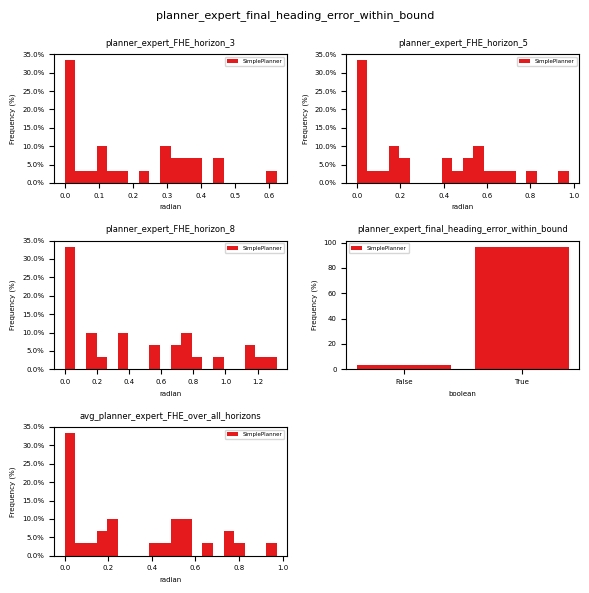

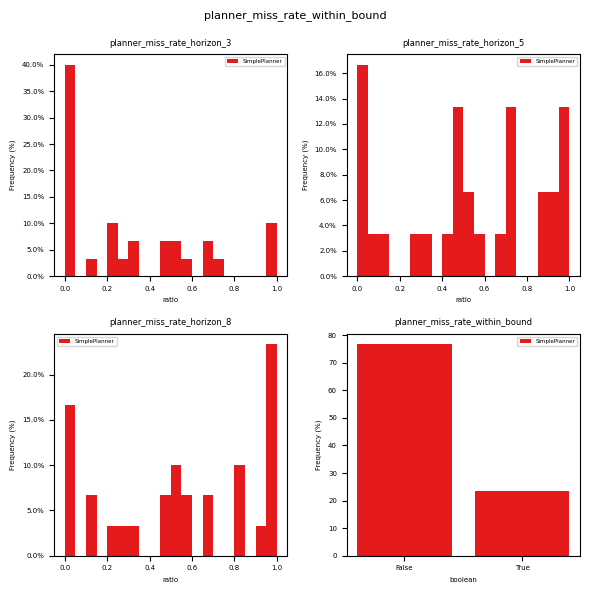

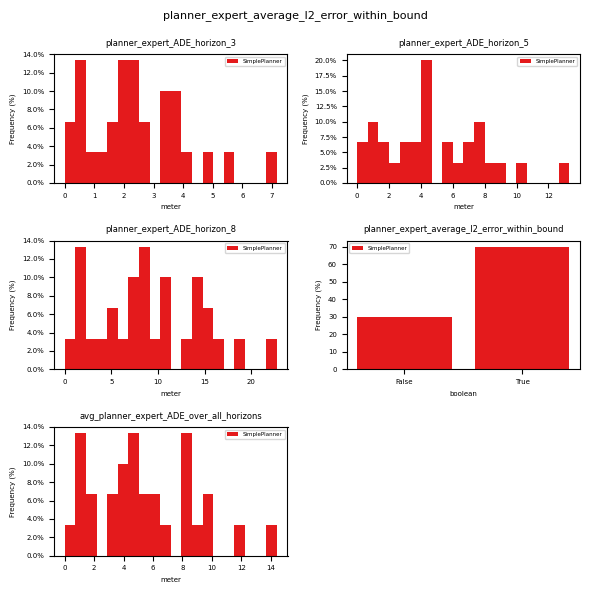

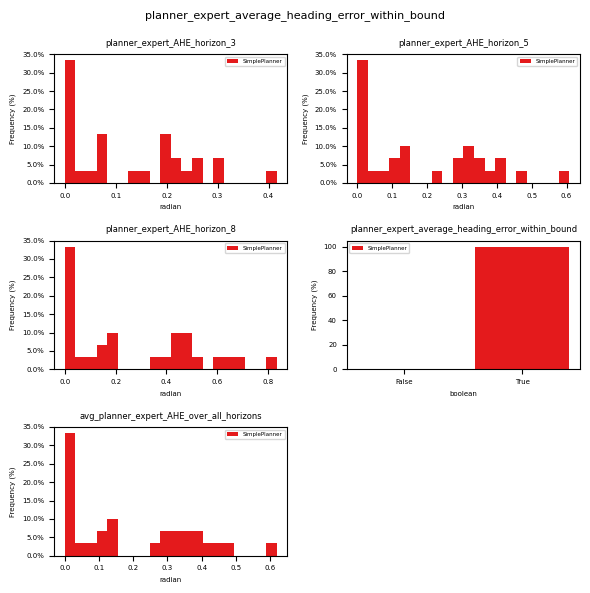

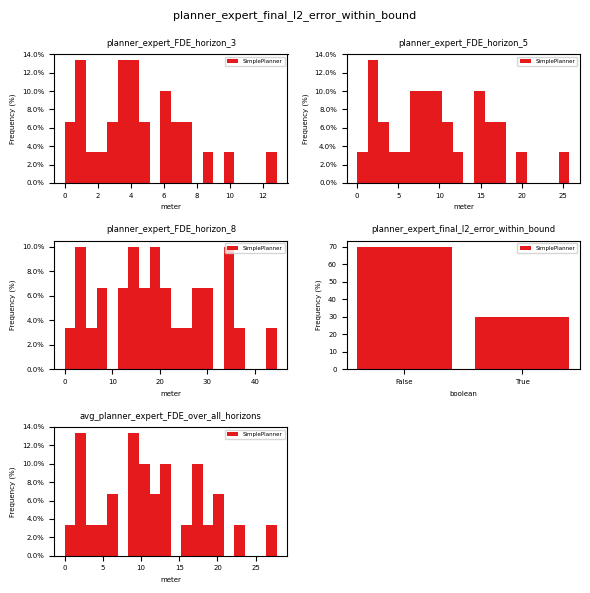

In [8]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

## Launch simulation (command line - alternative)

A simulation experiment can be launched alternatively with:
```
$ python nuplan/planning/script/run_simulation.py \
    +simulation=open_loop_boxes \
    planner=simple_planner \
    scenario_builder=nuplan_mini \
    scenario_filter=all_scenarios \
    scenario_filter.scenario_types="[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]" \
    scenario_filter.num_scenarios_per_type=10 \
```

## Simulate a trained ML planner for comparison

Using the same simulation settings as before, we can simulate a pretrained ML planner and compare the two.

In this example you can take the model you trained earlier.

Global seed set to 0


2023-07-06 15:32:28,008 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-07-06 15:32:28,032 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-07-06 15:32:28,235 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-07-06 15:32:28,235 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-07-06 15:32:28,237 WARNING {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2023-07-06 15:32:28,237 WARNING {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2023-07-06 15:32:31,115 INFO {/home/nishka/nuplan-devkit/nup

2023-07-06 15:32:33,114	INFO worker.py:1636 -- Started a local Ray instance.


2023-07-06 15:32:34,093 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-07-06 15:32:34,093 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-07-06 15:32:34,094 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 0
Number of threads across all nodes: 12
2023-07-06 15:32:34,094 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 0
Number of threads across all nodes: 12
2023-07-06 15:32:34,094 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-07-06 15:32:34,094 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Buildi

Ray objects: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.91it/s]


2023-07-06 15:32:36,584 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2023-07-06 15:32:36,584 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2023-07-06 15:32:36,611 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2023-07-06 15:32:36,611 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2023-07-06 15:32:36,611 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 30 scenarios...
2023-07-06 15:32:36,611 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 30 scenarios...
2023-07-06 15:32:36,613 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.p

2023-07-06 15:32:40,017 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:40,017 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:40,277 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:40,277 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:40,297 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:269}  Converted input conv conv1 pretrained weights f

2023-07-06 15:32:44,041 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:44,041 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:44,298 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:44,298 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:44,319 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:269}  Converted input conv conv1 pretrained weights f

2023-07-06 15:32:48,041 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:48,041 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:48,302 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:48,302 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:48,321 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:269}  Converted input conv conv1 pretrained weights f

2023-07-06 15:32:52,087 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:52,087 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:52,345 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:52,345 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:52,365 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:269}  Converted input conv conv1 pretrained weights f

2023-07-06 15:32:55,976 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:55,976 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-07-06 15:32:56,236 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:56,236 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-07-06 15:32:56,257 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:269}  Converted input conv conv1 pretrained weights f

(wrapped_fn pid=92427) /home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(wrapped_fn pid=92427)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Ray objects: 100%|██████████████████████████████| 30/30 [03:54<00:00,  7.83s/it]


2023-07-06 15:36:56,897 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 30
2023-07-06 15:36:56,897 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 30
2023-07-06 15:36:56,897 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-07-06 15:36:56,897 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-07-06 15:36:56,897 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-07-06 15:36:56,897 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-07-06 15:36:56,915 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /tmp/tutorial_nuplan_framework/simulation_raster_experiment/op

Rendering histograms: 100%|███████████████████████| 6/6 [00:02<00:00,  2.94it/s]


2023-07-06 15:37:01,148 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:03 [HH:MM:SS]
2023-07-06 15:37:01,148 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:03 [HH:MM:SS]
2023-07-06 15:37:01,149 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!
2023-07-06 15:37:01,149 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!


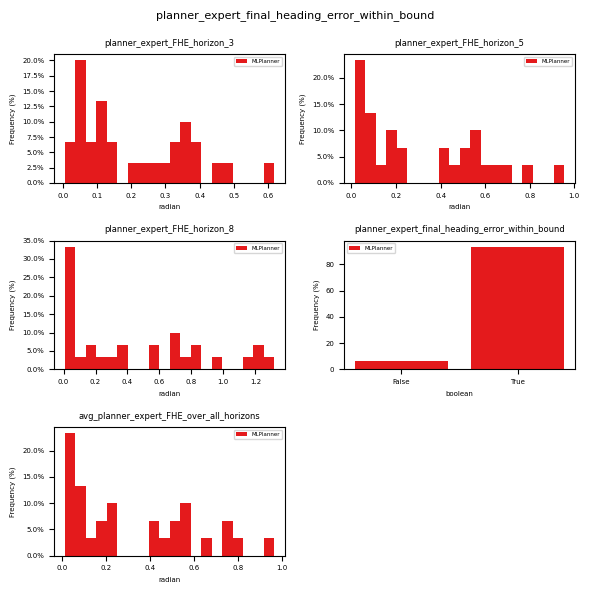

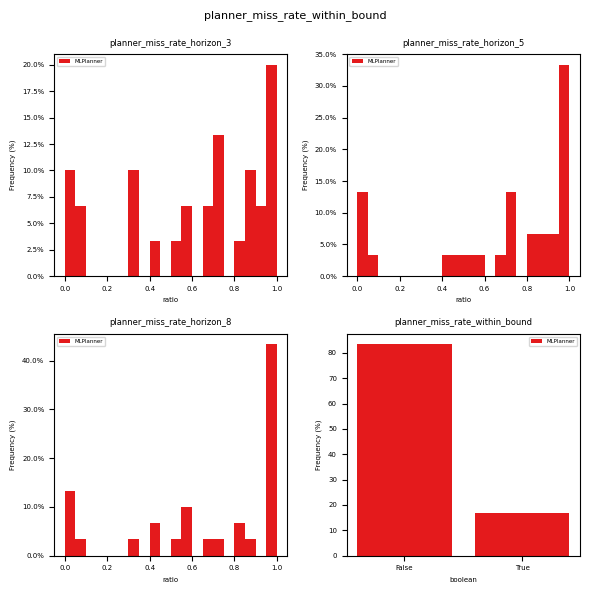

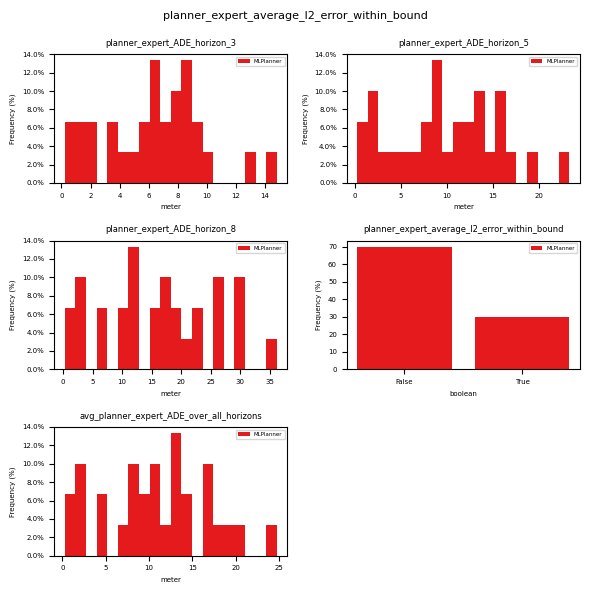

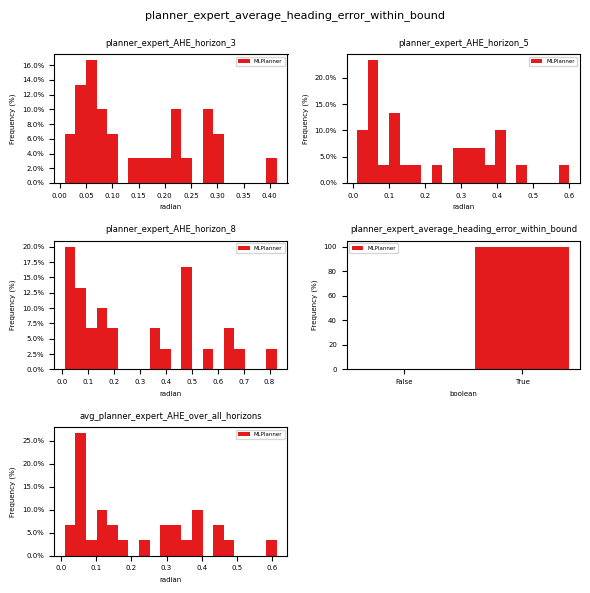

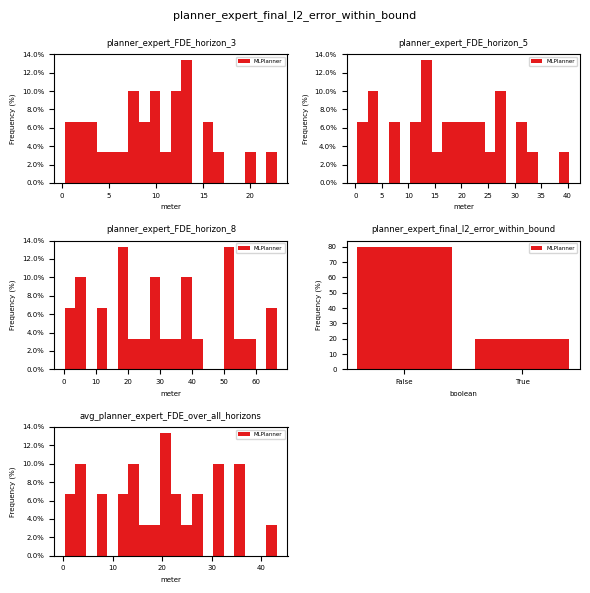

In [9]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Get the checkpoint of the trained model
last_experiment = sorted(os.listdir(LOG_DIR))[-1]
train_experiment_dir = sorted(LOG_DIR.iterdir())[-1]
checkpoint = sorted((train_experiment_dir / 'checkpoints').iterdir())[-1]

MODEL_PATH = str(checkpoint).replace("=", "\=")

# Name of the experiment
EXPERIMENT = 'simulation_raster_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    'planner=ml_planner',
    'model=raster_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={MODEL_PATH}',  # this path can be replaced by the checkpoint of the model trained in the previous section
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

# Run the simulation loop
main_simulation(cfg)

# ML_planner simulation folder for visualization in nuBoard (next section)
ml_planner_simulation_folder = cfg.output_dir

# Visualizing metrics and scenarios <a name="dashboard"></a>

## nuBoard summary

Having trained and simulated planners across various scenarios and driving behaviors, it's time to evaluate them:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [10]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[simple_simulation_folder, ml_planner_simulation_folder]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])

## Launch nuBoard (open in new tab - recommended)

In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.3.2)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


2023-07-06 15:40:24,255 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-07-06 15:40:24,255 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-07-06 15:40:24,272 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-07-06 15:40:24,272 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-07-06 15:40:24,273 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-07-06 15:40:24,273 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-07-06 15:40:24,273 INFO {/home/nishka/nuplan-devkit

INFO:tornado.access:200 GET / (127.0.0.1) 400.62ms


2023-07-06 15:40:26,203 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-06 15:40:26,203 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-06 15:40:26,231 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0012 seconds.
2023-07-06 15:40:26,231 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0012 seconds.
2023-07-06 15:40:26,360 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 295.46ms
2023-07-06 15:40:26,360 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 295.46ms
2023-07-06 15:40:26,408 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /r

INFO:tornado.access:200 GET / (127.0.0.1) 295.46ms
INFO:tornado.access:200 GET /resource/spectre.min.css (127.0.0.1) 24.14ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (127.0.0.1) 51.73ms
INFO:tornado.access:200 GET /resource/spectre-icons.min.css (127.0.0.1) 95.47ms
INFO:tornado.access:200 GET /resource/style.css (127.0.0.1) 95.70ms
INFO:tornado.access:200 GET /resource/css/overview.css (127.0.0.1) 138.47ms
INFO:tornado.access:200 GET /resource/css/cloud.css (127.0.0.1) 149.26ms
INFO:tornado.access:200 GET /resource/css/histogram.css (127.0.0.1) 1.96ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=3c61e952b808bb7e346ce828a565a5f23aaf7708d034fa9d0906403813355d45bb4e8d8b0b23a93f032c76831d4f0221846f28699c7f5147caa62e0d31668314 (127.0.0.1) 3.60ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=e5df31fd9010eacff0aa72d315264604b5e34972ba445acea6fce98080eecf33acf2d2986126360faaa5852813cffa16f6f6f4889923318300f062497c02da4e (127.0.0.1) 4.24ms


2023-07-06 15:40:26,460 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-exp.min.css (127.0.0.1) 51.73ms
2023-07-06 15:40:26,460 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-exp.min.css (127.0.0.1) 51.73ms
2023-07-06 15:40:26,505 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-icons.min.css (127.0.0.1) 95.47ms
2023-07-06 15:40:26,505 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-icons.min.css (127.0.0.1) 95.47ms
2023-07-06 15:40:26,505 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/style.css (127.0.0.1) 95.70ms
2023-07-06 15:40:26,505 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/st

INFO:tornado.access:200 GET /static/js/bokeh-widgets.min.js?v=8a1ff6f5aa0d967f4998d275803bbb111d928fd9f605ef9e1f30cfd021df0e77224ee3d13f83edb3a942f6e4ccc569ee5dd8951a8aa6cb600602463b90c65a87 (127.0.0.1) 5.84ms
INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (127.0.0.1) 6.94ms
INFO:tornado.access:200 GET /resource/css/scenario.css (127.0.0.1) 1.09ms
INFO:tornado.access:200 GET /static/js/bokeh-mathjax.min.js?v=176c36fdbcd8fc1019fc828101a2804081a35baf4018d7f2633cd263156b593aa73112f400112b662daa0590138b74851bc91f1f2a5fbf5416ee8c876c3e0d0c (127.0.0.1) 3.41ms
INFO:tornado.access:200 GET /resource/scripts/utils.js (127.0.0.1) 3.85ms
INFO:tornado.access:200 GET /resource/motional_logo.png (127.0.0.1) 1.19ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.77ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerConnectio

2023-07-06 15:40:26,856 WARNING {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  404 GET /favicon.ico (127.0.0.1) 0.91ms
2023-07-06 15:40:26,856 WARNING {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  404 GET /favicon.ico (127.0.0.1) 0.91ms
2023-07-06 15:40:26,889 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.77ms
2023-07-06 15:40:26,889 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.77ms
2023-07-06 15:42:53,374 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-06 15:42:53,374 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-06 15:42:53,406 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rend

INFO:tornado.access:200 GET / (127.0.0.1) 318.33ms
INFO:tornado.access:200 GET /resource/spectre.min.css (127.0.0.1) 0.64ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.46ms


2023-07-06 15:42:53,727 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-06 15:42:53,727 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-06 15:42:53,757 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0012 seconds.
2023-07-06 15:42:53,757 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0012 seconds.
2023-07-06 15:42:53,895 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 295.86ms
2023-07-06 15:42:53,895 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 295.86ms
2023-07-06 15:42:53,913 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /r

INFO:tornado.access:200 GET / (127.0.0.1) 295.86ms
INFO:tornado.access:200 GET /resource/spectre.min.css (127.0.0.1) 0.59ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.91ms
INFO:tornado.access:200 GET /resource/spectre-icons.min.css (127.0.0.1) 0.89ms
INFO:tornado.access:200 GET /resource/style.css (127.0.0.1) 0.35ms
INFO:tornado.access:200 GET /resource/css/overview.css (127.0.0.1) 0.42ms
INFO:tornado.access:200 GET /resource/css/cloud.css (127.0.0.1) 0.43ms
INFO:tornado.access:200 GET /resource/css/scenario.css (127.0.0.1) 0.39ms
INFO:tornado.access:200 GET /resource/css/histogram.css (127.0.0.1) 0.41ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=3c61e952b808bb7e346ce828a565a5f23aaf7708d034fa9d0906403813355d45bb4e8d8b0b23a93f032c76831d4f0221846f28699c7f5147caa62e0d31668314 (127.0.0.1) 1.35ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=e5df31fd9010eacff0aa72d315264604b5e34972ba445acea6fce98080eecf33acf2d2986126360faaa5852813cffa16f6f6

2023-07-06 15:42:53,930 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (127.0.0.1) 1.46ms
2023-07-06 15:42:53,930 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (127.0.0.1) 1.46ms
2023-07-06 15:42:53,932 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-mathjax.min.js?v=176c36fdbcd8fc1019fc828101a2804081a35baf4018d7f2633cd263156b593aa73112f400112b662daa0590138b74851bc91f1f2a5fbf5416ee8c876c3e0d0c (127.0.0.1) 1.80ms
2023-07-06 15:42:53,932 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site

INFO:tornado.access:200 GET /resource/motional_logo.png (127.0.0.1) 1.29ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 1.06ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerConnection created


2023-07-06 15:42:54,631 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 1.06ms
2023-07-06 15:42:54,631 INFO {/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 1.06ms


INFO:bokeh.server.views.ws:WebSocket connection closed: code=1001, reason=None


2023-07-06 15:55:49,255 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0202 seconds.
2023-07-06 15:55:49,255 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0202 seconds.
2023-07-06 15:55:50,271 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0201 seconds.
2023-07-06 15:55:50,271 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0201 seconds.


INFO:bokeh.server.views.ws:WebSocket connection closed: code=1001, reason=None


## Launch nuBoard (embedded within the notebook - alternative)

In [ ]:
from bokeh.io import show, output_notebook
from nuplan.planning.script.run_nuboard import initialize_nuboard

# Make sure that the notebook working directory is "/notebooks" and that Jupyter was launched at the root of the repo
cfg.resource_prefix = '/notebooks/nuplan/planning/metrics/board/'  # pass CSS resources to the notebook

# Run the nuBoard
output_notebook()
nuboard = initialize_nuboard(cfg)
show(nuboard.main_page)

## Launch nuBoard (command line - alternative)

nuBoard can be launched alternatively with:
```
$ python nuplan/planning/script/run_nuboard.py
```

Simulation files (.nuboard) can be selected under the configuration tab.